# Bank Customer Chun Prediction 
## 1. Dataset Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Define the dataset path
bank_dataset_path = "bank.csv"

# Load numeric columns
credit_score = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[1]).astype(float)
age = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[4]).astype(float)
tenure = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[5]).astype(int)
balance = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[6]).astype(float)
products_number = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[7]).astype(int)
credit_card = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[8]).astype(int)
active_member = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[9]).astype(int)
estimated_salary = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[10]).astype(float)
churn = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[11]).astype(int)

# Encode categorical variables
country = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[2], dtype=str)
country_france = np.where(country == 'France', 1, 0).astype(int)
country_spain = np.where(country == 'Spain', 1, 0).astype(int)
country_germany = np.where(country == 'Germany', 1, 0).astype(int)
gender = np.genfromtxt(bank_dataset_path, delimiter=",", skip_header=1, usecols=[3], dtype=str)
gender_encoded = np.where(gender == 'Female', 1, 0).astype(int)

# Combine all features into a single input matrix
bank_input = np.c_[credit_score, age, tenure, balance, products_number, credit_card, active_member, 
                    estimated_salary, country_france, country_spain, country_germany, gender_encoded]
feature_names = [
    'Credit Score', 'Age', 'Tenure', 'Balance', 'Products Number', 
    'Credit Card', 'Active Member', 'Estimated Salary', 
    'Country France', 'Country Spain', 'Country Germany', 'Gender'
]

# Reshape churn column to match the format
bank_labels = churn.reshape(-1, 1)

# Bank input information
print(f"Bank input: {bank_input.shape[0]} samples, {bank_input.shape[0]} features")

# Target label information
unique, counts = np.unique(bank_labels, return_counts=True)
class_labels = {0: "Not Churned", 1: "Churned"}
for value, count in zip(unique, counts):
    print(f"{class_labels[value]}: {count} ({(count / len(bank_labels)) * 100:.2f}%)")

Bank input: 10000 samples, 10000 features
Not Churned: 7963 (79.63%)
Churned: 2037 (20.37%)


## 2. Data Standardisation Visualisation

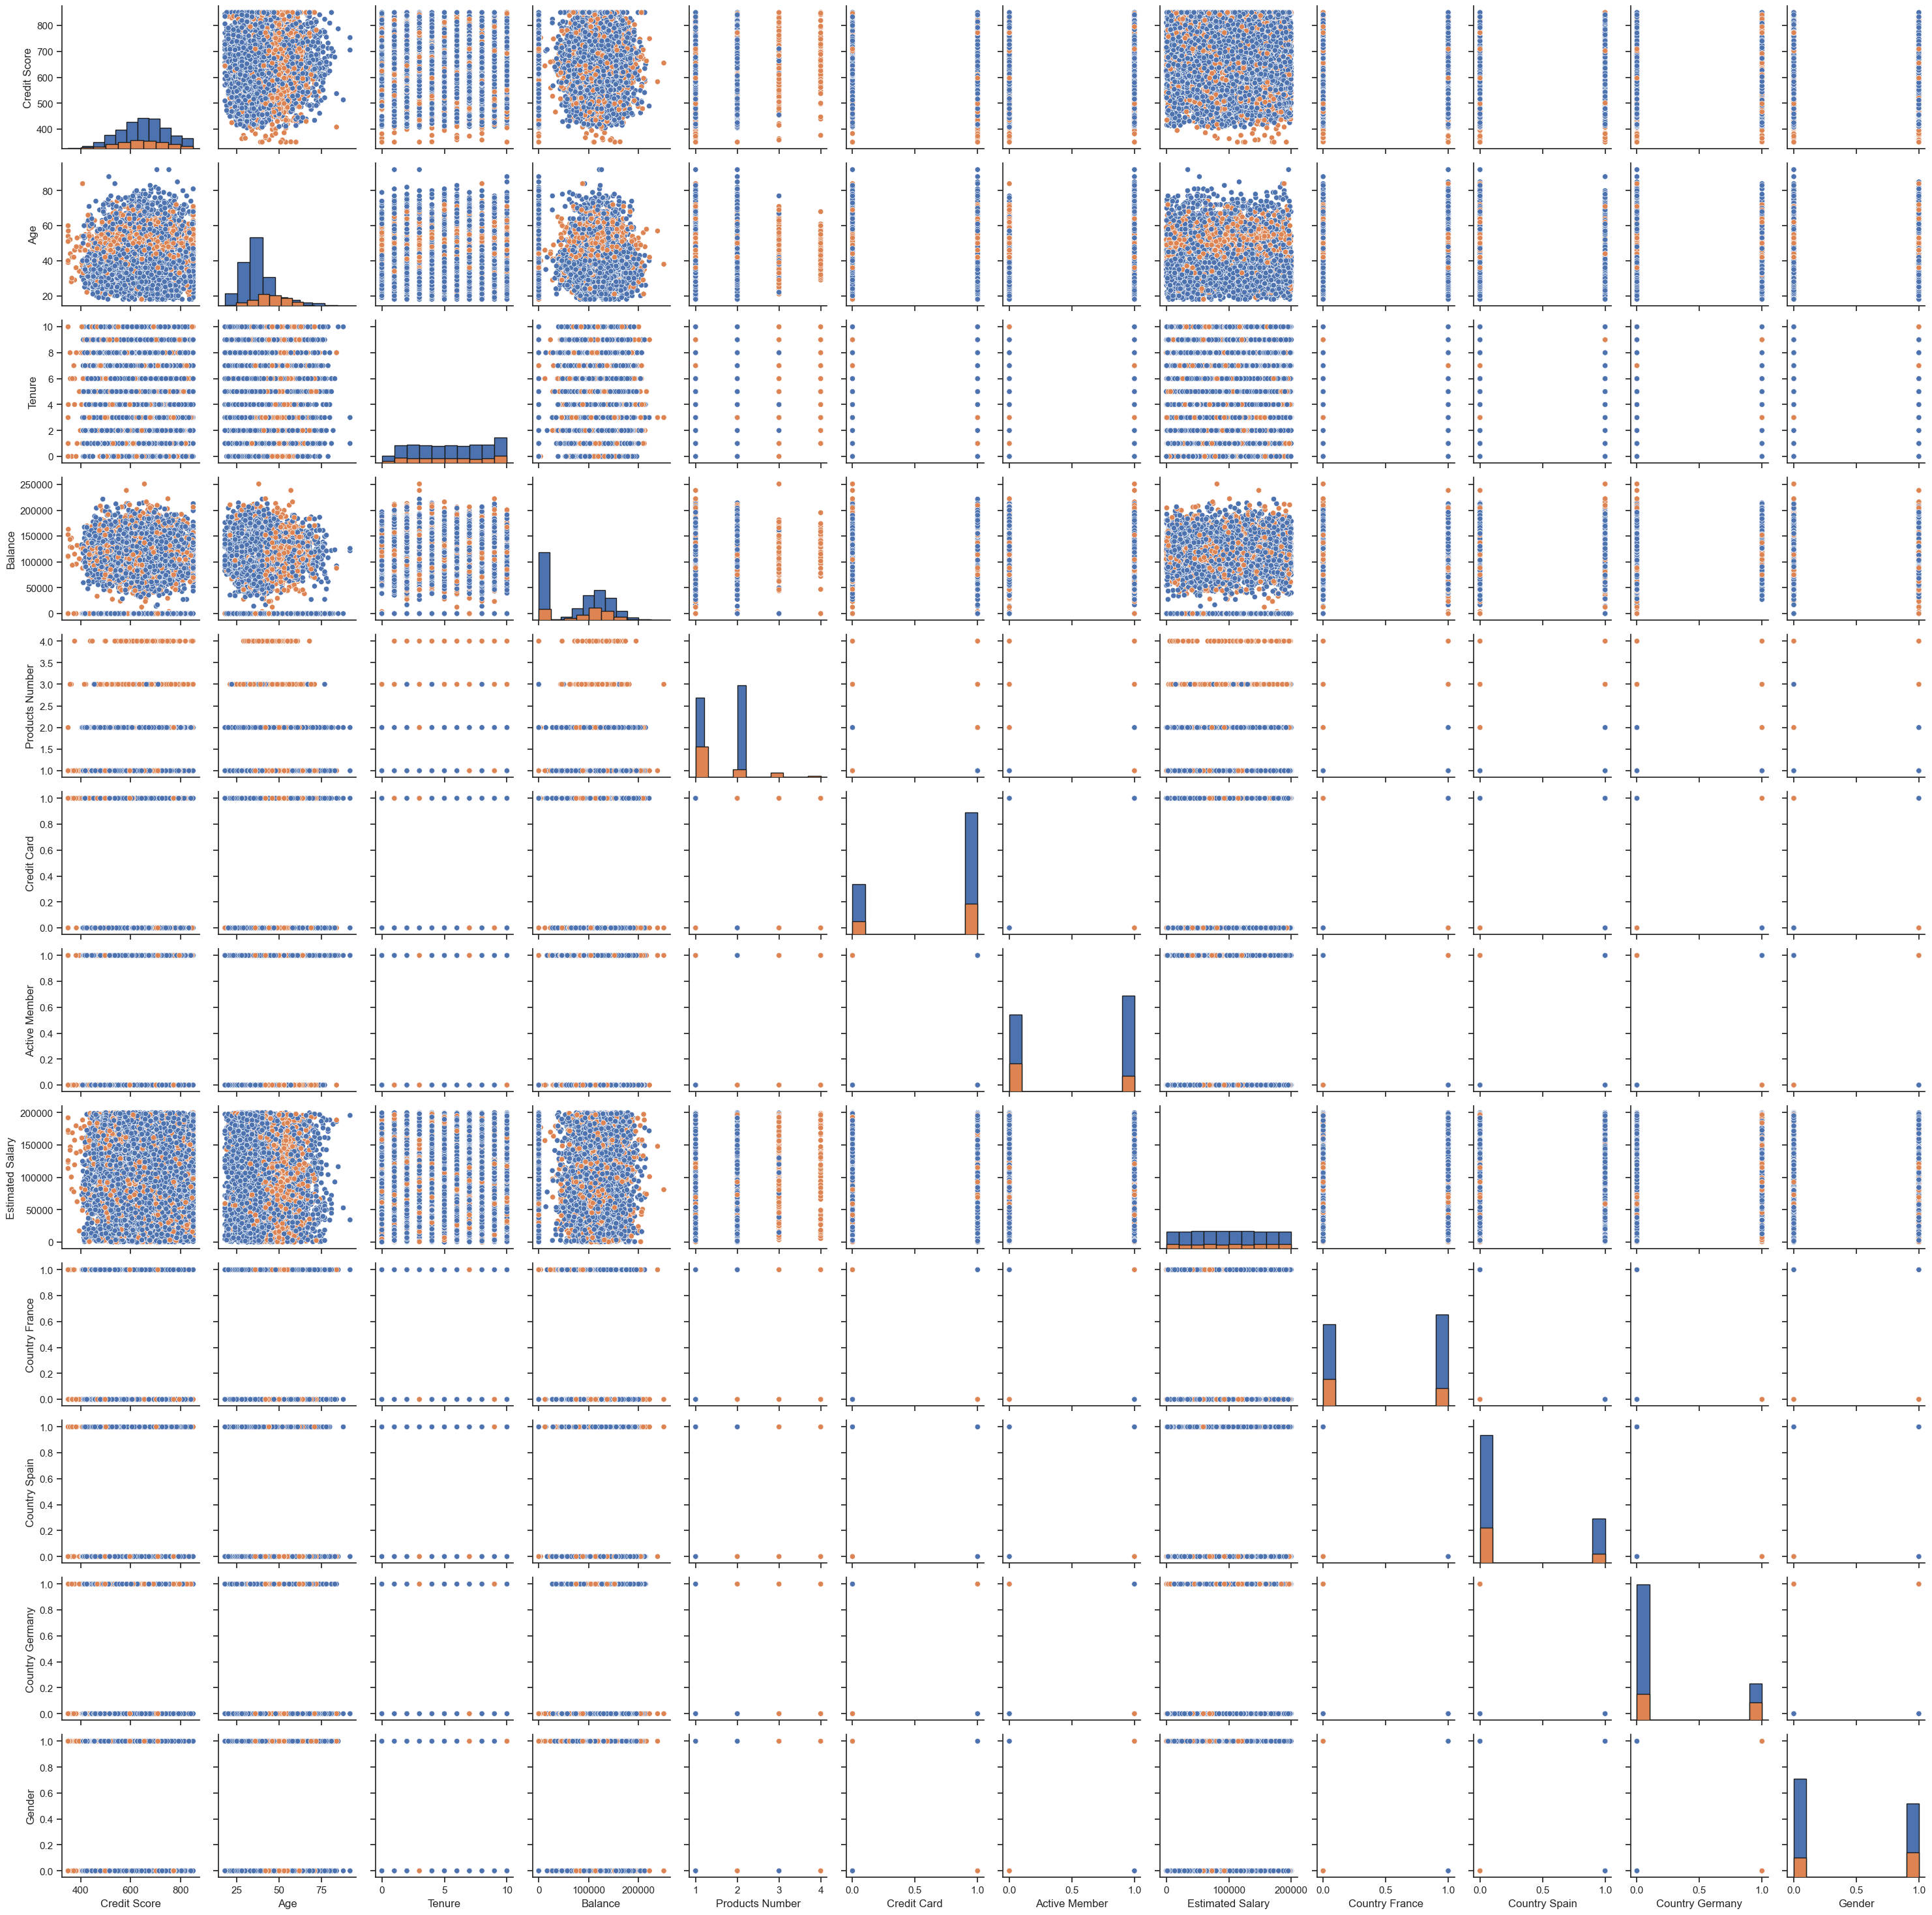

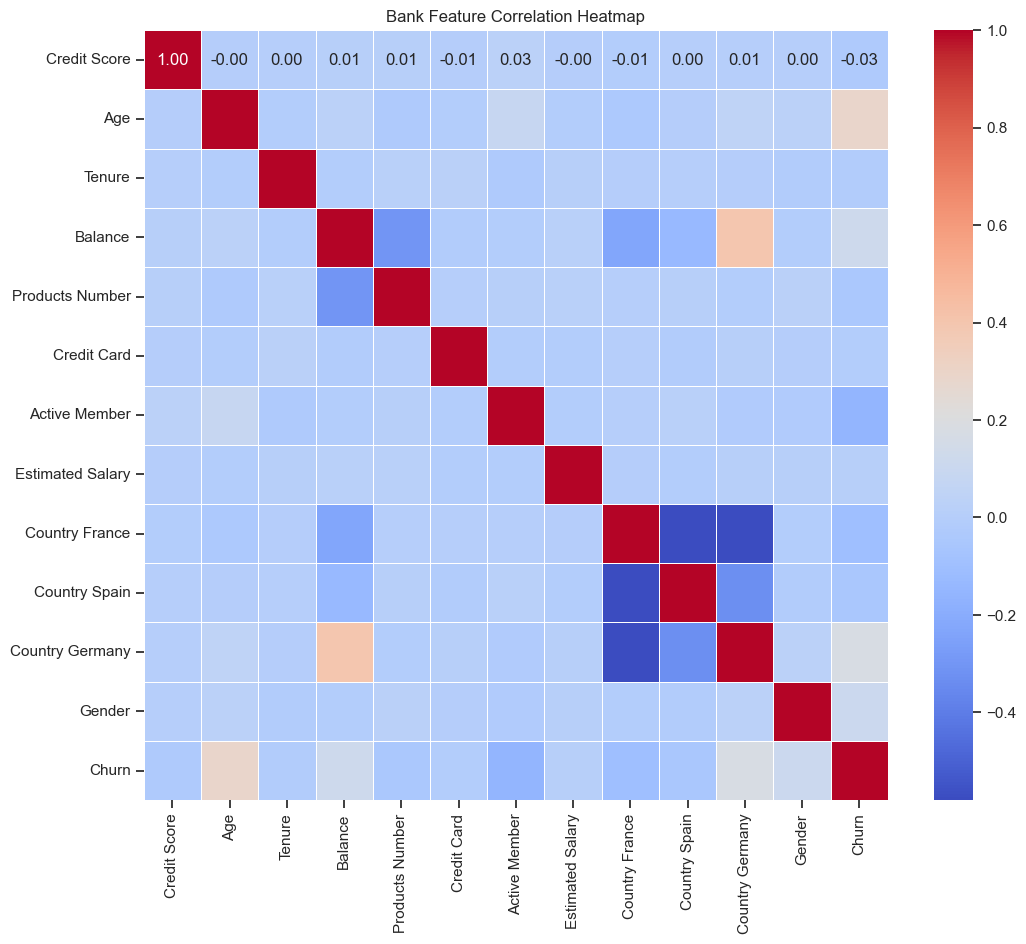

<Figure size 640x480 with 0 Axes>

In [3]:
# A function to standardise the given data matrix
def standardise(data_matrix):
    row_of_means = np.mean(data_matrix, axis=0)
    standardised_matrix = data_matrix - row_of_means
    row_of_stds = np.std(standardised_matrix, axis=0)
    return (standardised_matrix / row_of_stds), row_of_means, row_of_stds

# A function to de-standardise the given data matrix
def de_standardise(standardised_matrix, row_of_means, row_of_stds):
    matrix = np.copy(standardised_matrix * row_of_stds)
    return matrix + row_of_means

# Standardise the bank input features
bank_input, bank_row_of_means, bank_row_of_stds = standardise(bank_input)

# A function to plot the bank data
def plot_bank(data_input, data_output):

    # Prepare dataset with features and churn labels
    num_features = data_input.shape[1]
    bank_de_standardised = de_standardise(data_input, bank_row_of_means, bank_row_of_stds)
    bank_dataframe = pd.DataFrame(data=bank_de_standardised, columns=feature_names)
    bank_dataframe['Churn'] = data_output

    # Pairwise scatter plot for visualising feature relationships
    sns.set_theme(style="ticks", color_codes=True)
    g = sns.PairGrid(bank_dataframe, vars=feature_names, hue='Churn')
    g.map_offdiag(sns.scatterplot)
    g.map_diag(plt.hist, edgecolor='k')

    # Correlation heatmap of features
    plt.figure(figsize=(12, 10))
    correlation_matrix = bank_dataframe.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title('Bank Feature Correlation Heatmap')
    plt.show()

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()

# Call the function to visualise bank data
plot_bank(bank_input, bank_labels)

## 3. Model: Logistic Regression with L2 Regularisation and ROC

In [4]:
# A function to add a bias column to the input data
def prepare_regression_data(input_data):
    bias_column = np.ones((len(input_data), 1))
    return np.c_[bias_column, input_data]

# A function to compute the linear model output
def compute_model_output(input_matrix, weights):
    return input_matrix @ weights

# A function to apply the sigmoid function
def sigmoid_function(values):
    return 1 / (1 + np.exp(-values))

# A function to predict binary class labels
def classify_binary(input_data, weights):
    probabilities = sigmoid_function(compute_model_output(input_data, weights))
    return probabilities > 0.5

# A function to compute the logistic regression cost function with L2 regularisation
def compute_logistic_cost_l2(input_data, target_labels, weights, lambda_reg):
    predictions = compute_model_output(input_data, weights)
    log_loss = np.mean(np.log(1 + np.exp(predictions)) - target_labels * predictions)
    regularisation_term = (lambda_reg / (2 * len(input_data))) * np.sum(weightsr[1:] ** 2)
    return log_loss + regularisation_term

# A function to tompute the gradient of the logistic regression cost function with L2 regularisation
def compute_logistic_gradient_l2(input_data, target_labels, weights, lambda_reg):
    predictions = sigmoid_function(compute_model_output(input_data, weights))
    errors = predictions - target_labels
    gradient = input_data.T @ errors / len(input_data)
    gradient[1:] += (lambda_reg / len(input_data)) * weights[1:]
    return gradient

# A function to measure classification accuracy
def classification_accuracy(estimated_labels, true_labels):
    return np.mean(estimated_labels == true_labels)

# A function to perform gradient descent with L2 regularization
def gradient_descent_l2(cost_function, gradient_function, initial_weights, input_data, target_labels, lambda_reg, learning_rate, num_iterations=100):
    weights = np.copy(initial_weights)
    for i in range(num_iterations):
        gradient = gradient_function(input_data, target_labels, weights, lambda_reg)
        weights -= learning_rate * gradient.reshape(-1, 1)
    return weights

# A function to split into K-Fold
def kfold_split(data_size, num_folds):
    indices = np.random.permutation(data_size)
    fold_size, remainder = divmod(data_size, num_folds)
    return [
        indices[i * fold_size + min(i, remainder):(i + 1) * fold_size + min(i + 1, remainder)]
        for i in range(num_folds)
    ]

# A function to perform K-Fold cross-validation for logistic regression with L2 regularisation
def kfold_cross_validation_logistic_l2(input_data, target_labels, num_folds, cost_function, gradient_function, lambda_reg):
    fold_indices = kfold_split(len(input_data), num_folds)
    total_accuracy = 0

    # Split data into training and testing sets
    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]

        train_input = prepare_regression_data(input_data[train_indices])
        test_input = prepare_regression_data(input_data[test_indices])
        train_labels = target_labels[train_indices].reshape(-1, 1)
        test_labels = target_labels[test_indices].reshape(-1, 1)

        # Train the model using gradient descent
        initial_weights = np.zeros((train_input.shape[1], 1))
        learning_rate = 3.9 * len(train_input) / (np.linalg.norm(train_input))**2

        optimal_weights = gradient_descent_l2(
            cost_function, gradient_function, initial_weights,
            train_input, train_labels, lambda_reg, learning_rate, 2000
        )

        # Predict on test set
        predicted_labels = classify_binary(test_input, optimal_weights)

        # Calculate accuracy
        fold_accuracy = classification_accuracy(predicted_labels, test_labels)
        total_accuracy += fold_accuracy / num_folds

    return total_accuracy

# A function to perform grid search for optimal regularisation parameter
def grid_search_l2(input_data, target_labels, num_folds, cost_function, gradient_function, lambda_values):
    optimal_lambda = None
    best_accuracy = 0

    # Perform k-fold cross-validation
    for lambda_reg in lambda_values:
        accuracy = kfold_cross_validation_logistic_l2(input_data, target_labels, num_folds, cost_function, gradient_function, lambda_reg)
        print(f"Lambda: {lambda_reg}, Accuracy: {accuracy:.2%}")

        # Update the optimal lambda value
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            optimal_lambda = lambda_reg

    return optimal_lambda, best_accuracy

# Logistic regression cost and gradient functions with L2 regularisation
def logistic_cost_function_l2(input_data, target_labels, weights, lambda_reg):
    return compute_logistic_cost_l2(input_data, labels, weights, lambda_reg)

def logistic_gradient_function_l2(input_data, target_labels, weights, lambda_reg):
    return compute_logistic_gradient_l2(input_data, target_labels, weights, lambda_reg)

# Perform grid search for optimal lambda value
lambda_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
optimal_lambda, optimal_accuracy = grid_search_l2(
    bank_input, bank_labels, num_folds, logistic_cost_function_l2, logistic_gradient_function_l2, lambda_values
)

print(f"Optimal Lambda: {optimal_lambda}, Best Cross-Validation Accuracy: {optimal_accuracy:.2%}")

# Train the final model using the optimal lambda value
final_input_data = prepare_regression_data(bank_input)
initial_weights = np.zeros((final_input_data.shape[1], 1))
final_learning_rate = 3.9 * len(final_input_data) / (np.linalg.norm(final_input_data))**2

optimal_weights_l2 = gradient_descent_l2(
    logistic_cost_function_l2, logistic_gradient_function_l2, initial_weights,
    final_input_data, bank_labels, optimal_lambda, final_learning_rate, 2000
)

# Final model prediction with L2 regularisation
bank_predicted_labels_l2 = classify_binary(final_input_data, optimal_weights_l2)

# Final model accuracy
final_accuracy_l2 = classification_accuracy(bank_predicted_labels_l2, bank_labels)

# Print final results
print("Optimal Weights from Logistic Regression with L2 Regularisation:")
print(optimal_weights_l2)
print(f"Final Accuracy after L2 Regularisation: {final_accuracy_l2:.2%}")



Lambda: 0.001, Accuracy: 81.09%
Lambda: 0.01, Accuracy: 81.06%
Lambda: 0.1, Accuracy: 80.98%
Lambda: 1, Accuracy: 81.07%
Lambda: 10, Accuracy: 81.05%
Optimal Lambda: 0.001, Best Cross-Validation Accuracy: 81.09%
Optimal Weights from Logistic Regression with L2 Regularisation:
[[-1.65346084]
 [-0.06459292]
 [ 0.76248772]
 [-0.04612524]
 [ 0.16453794]
 [-0.05904813]
 [-0.02036427]
 [-0.537476  ]
 [ 0.02764384]
 [-0.12187322]
 [-0.09001735]
 [ 0.23019055]
 [ 0.26313511]]
Final Accuracy after L2 Regularisation: 81.03%


Average Accuracy from K-Fold: 81.00%


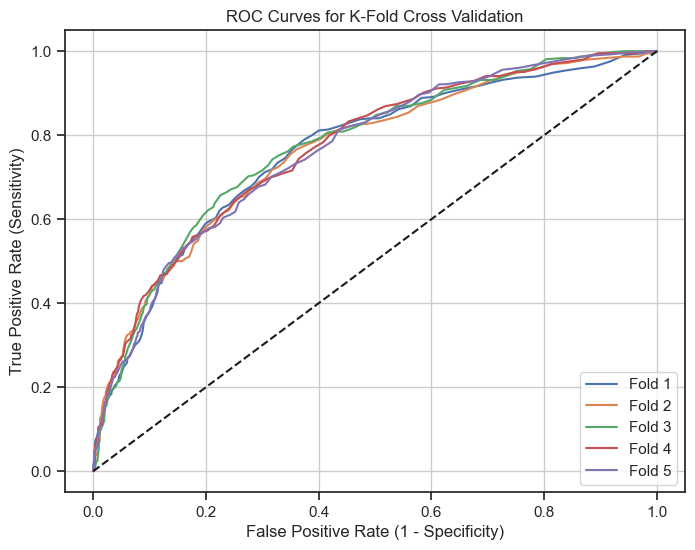

In [5]:
# A function to perform K-Fold cross-validation for ROC
def perform_kfold_logistic_regression_roc(input_data, target_labels, num_folds, cost_function, gradient_function, lambda_reg):
    fold_indices = kfold_split(len(input_data), num_folds)
    total_accuracy = 0
    values_ROC = {}

    # Split data into training and testing sets
    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]

        # Prepare data
        train_input = prepare_regression_data(input_data[train_indices])
        test_input = prepare_regression_data(input_data[test_indices])
        train_labels = target_labels[train_indices].reshape(-1, 1)
        test_labels = target_labels[test_indices].reshape(-1, 1)

        # Train the model using gradient descent
        initial_weights = np.zeros((train_input.shape[1], 1))
        learning_rate = 3.9 * len(train_input) / (np.linalg.norm(train_input))**2

        optimal_weights = gradient_descent_l2(
            cost_function, gradient_function, initial_weights,
            train_input, train_labels, lambda_reg, learning_rate, 2000
        )

        # Compute ROC values
        threshold = 0.0
        delta_t = 0.005
        roc_values = []
        while threshold <= 1:
            predicted_labels = predict_with_threshold(test_input, optimal_weights, threshold)
            tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

            TPR = tp / (tp + fn)
            FPR = fp / (tn + fp)

            roc_values.append([FPR, TPR, threshold])
            threshold += delta_t

        values_ROC[i] = roc_values

        # Compute accuracy
        final_predictions = classify_binary(test_input, optimal_weights)
        fold_accuracy = classification_accuracy(final_predictions, test_labels)
        total_accuracy += fold_accuracy

    average_accuracy = total_accuracy / num_folds
    return optimal_weights, average_accuracy, values_ROC

# A function to predict with threshold
def predict_with_threshold(data_input, weights, threshold):
    probabilities = sigmoid_function(compute_model_output(data_input, weights))
    return probabilities > threshold

# Perform K-Fold cross-validation for ROC
K = 5
optimal_weights_k_fold, average_accuracy, values_ROC = perform_kfold_logistic_regression_roc(
    bank_input, bank_labels, K, compute_logistic_cost_l2, compute_logistic_gradient_l2, optimal_lambda
)
print(f"Average Accuracy from K-Fold: {average_accuracy:.2%}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in values_ROC:
    fpr_values = [item[0] for item in values_ROC[i]]
    tpr_values = [item[1] for item in values_ROC[i]]
    plt.plot(fpr_values, tpr_values, label=f'Fold {i + 1}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for K-Fold Cross Validation')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## 4. Model: K-Nearest Neighbour

Optimal number of neighbours for KNN: 8
Final Accuracy after K-Fold Cross Validation (KNN): 75.84%


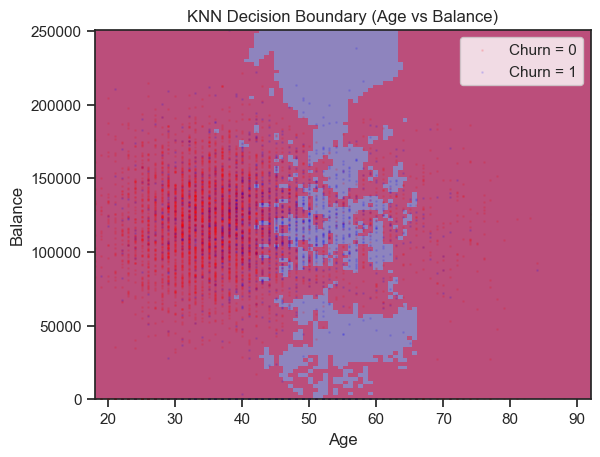

In [6]:
# A function to compute pairwise Euclidean distances between test and train data
def compute_pairwise_distances(test_input, train_input):
    return np.sqrt(np.sum((test_input[:, np.newaxis, :] - train_input[np.newaxis, :, :])**2, axis=2))

# A function to predict labels using K-Nearest Neighbours
def knn_predict(test_input, train_input, train_labels, num_neighbours):
    distances = compute_pairwise_distances(test_input, train_input)
    sorted_indices = np.argsort(distances, axis=1)
    sorted_labels = np.take_along_axis(train_labels.reshape(1, -1), sorted_indices, axis=1)
    predicted_labels = np.zeros(len(test_input), dtype=int)
    for i in range(len(test_input)):
        neighbour_counts = np.bincount(sorted_labels[i, :num_neighbours], minlength=np.max(train_labels) + 1)
        predicted_labels[i] = np.argmax(neighbour_counts)
    return predicted_labels

# A function to perform K-Fold cross-validation for KNN
def kfold_cross_validation_knn(input_data, target_labels, num_folds, predict_labels, calculate_accuracy, num_neighbours):
    indices = kfold_split(len(input_data), num_folds)
    avg_accuracy = 0
    for i in range(num_folds):
        train_indices = np.concatenate([indices[j] for j in range(num_folds) if j != i])
        predicted_labels = predict_labels(input_data[indices[i]], input_data[train_indices], target_labels[train_indices], num_neighbours)
        accuracy = calculate_accuracy(predicted_labels, target_labels[indices[i]])
        avg_accuracy += accuracy / num_folds
    return 1.0 - avg_accuracy

# A function to perform grid search to find the optimal number of neighbours
def grid_search_knn(objective_function, knn_param_grid):
    errors = np.array([objective_function(param) for param in knn_param_grid])
    return knn_param_grid[np.argmin(errors)]

# Select specific columns: Age, Balance
selected_columns = [1, 3]
bank_input_selected = bank_input[:, selected_columns]

# Define prediction function for KNN
predict_labels = lambda test_input, train_input, train_labels, k: knn_predict(test_input, train_input, train_labels, k)

# Set parameters
num_folds = 5

# Define the range of k values for grid search
knn_values = list(range(1, 21))

# Define knn objective function with selected features
knn_objective_function = lambda k: kfold_cross_validation_knn(bank_input_selected, bank_labels, num_folds, predict_labels, classification_accuracy, k)

# Run KNN with selected features only
optimal_k_knn = grid_search_knn(knn_objective_function, knn_values)
bank_predicted_labels_knn = knn_predict(bank_input_selected, bank_input_selected, bank_labels, optimal_k_knn)
final_accuracy_knn = classification_accuracy(bank_predicted_labels_knn, bank_labels)

# Print final results
print(f"Optimal number of neighbours for KNN: {optimal_k_knn}")
print(f"Final Accuracy after K-Fold Cross Validation (KNN): {final_accuracy_knn:.2%}")

# Generate a 100x100 grid for visualization
grid_seed_age = 100 
grid_seed_balance = 100

# Create evenly spaced grid points for Age and Balance
grid_age = np.linspace(np.min(bank_input_selected[:, 0]),
                       np.max(bank_input_selected[:, 0]), grid_seed_age)

grid_balance = np.linspace(np.min(bank_input_selected[:, 1]),
                           np.max(bank_input_selected[:, 1]), grid_seed_balance)

# Create a 2D meshgrid
age_grid_data, balance_grid_data = np.meshgrid(grid_age, grid_balance)

# Reshape the grid into (10000, 2) for prediction
full_grid_data = np.c_[age_grid_data.flatten(), balance_grid_data.flatten()]

# Reshape bank_labels is a 1D array
bank_labels = bank_labels.flatten()

# Predict labels using the trained KNN model
full_grid_labels = knn_predict(full_grid_data, bank_input_selected, bank_labels, optimal_k_knn)

# Reshape the predicted labels to match the grid shape for visualisation
full_grid_labels = full_grid_labels.reshape(grid_seed_age, grid_seed_balance)

# Extract the mean and standard deviation corresponding to the selected features
bank_row_of_means_selected = bank_row_of_means[selected_columns]
bank_row_of_stds_selected = bank_row_of_stds[selected_columns]

# De-standardise the selected features
bank_de_standardised = de_standardise(bank_input_selected, bank_row_of_means_selected, bank_row_of_stds_selected)

# Plot decision boundary using imshow
plt.imshow(full_grid_labels, cmap='Spectral', origin='lower',
           extent=[np.min(bank_de_standardised[:, 0]), np.max(bank_de_standardised[:, 0]),
                   np.min(bank_de_standardised[:, 1]), np.max(bank_de_standardised[:, 1])],
           aspect="auto", alpha=0.7)

# Plot the original data points on the plot
plt.scatter(bank_de_standardised[:, 0][bank_labels == 0],
            bank_de_standardised[:, 1][bank_labels == 0], s=1, c='red', alpha=0.1, label='Churn = 0')
plt.scatter(bank_de_standardised[:, 0][bank_labels == 1],
            bank_de_standardised[:, 1][bank_labels == 1], s=1, c='blue', alpha=0.1, label='Churn = 1')
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('KNN Decision Boundary (Age vs Balance)')
plt.legend()
plt.show()

## 5. Model: Support Vector Machine

In [7]:
# A function to compute the hinge loss for SVM
def hinge_loss(input_data, target_labels, weights, C):
    distances = 1 - target_labels * (input_data @ weights)
    distances = np.maximum(0, distances)
    loss = np.sum(distances) / len(target_labels)
    regularisation = (1/2) * np.dot(weights, weights)
    return regularisation + C * loss

# A function to compute the gradient of the hinge loss
def compute_hinge_gradient(input_data, target_labels, weights, C):
    distances = 1 - target_labels * (input_data @ weights)
    gradient = np.zeros_like(weights)
    
    for i, d in enumerate(distances):
        if d > 0:
            gradient -= C * target_labels[i] * input_data[i]
    
    gradient += weights
    return gradient / len(target_labels)

# A function to perform gradient descent to optimise the SVM model
def gradient_descent_svm(input_data, target_labels, learning_rate=0.01, num_iterations=1000, C=1.0):
    weights = np.zeros(input_data.shape[1])
    for i in range(num_iterations):
        gradient = compute_hinge_gradient(input_data, target_labels, weights, C)
        weights -= learning_rate * gradient
    return weights

# A function to make predictions using the trained SVM model
def svm_predict(input_data, weights):
    return np.sign(input_data @ weights)

# A function to perform K-Fold Cross Validation for SVM
def kfold_cross_validation_svm(input_data, target_labels, num_folds, learning_rate, num_iterations, C):
    fold_indices = kfold_split(len(input_data), num_folds)
    total_accuracy = 0

    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]

        train_input, train_labels = input_data[train_indices], target_labels[train_indices]
        test_input, test_labels = input_data[test_indices], target_labels[test_indices]

        # Train the SVM model using training data
        optimal_weights = gradient_descent_svm(train_input, train_labels, learning_rate, num_iterations, C)

        # Predict on the test set
        predicted_labels = svm_predict(test_input, optimal_weights)

        # Calculate accuracy
        accuracy = np.mean(predicted_labels == test_labels)
        total_accuracy += accuracy

    return total_accuracy / num_folds, optimal_weights

# A function to perform grid search to find the optimal C value
def grid_search_svm(input_data, target_labels, num_folds, learning_rate, num_iterations, C_values):
    best_C = None
    best_accuracy = 0
    best_weights = None

    for C in C_values:
        accuracy, weights = kfold_cross_validation_svm(input_data, target_labels, num_folds, learning_rate, num_iterations, C)
        print(f"Testing C={C}, Accuracy={accuracy:.2%}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_C = C
            best_weights = weights

    return best_C, best_accuracy, best_weights

bank_input_prepared = prepare_regression_data(bank_input)

# Convert labels to -1 and 1 for SVM
bank_labels_svm = np.where(bank_labels == 0, -1, 1)

# Set hyperparameters
num_folds = 5
learning_rate = 0.01
num_iterations = 1000
C_values = [0.01, 0.1, 1, 10]

# Perform grid search to find the optimal C value
optimal_C, best_accuracy, optimal_weights_svm = grid_search_svm(
    bank_input_prepared, bank_labels_svm, num_folds, learning_rate, num_iterations, C_values
)

# Final model evaluation using the best C value
final_predictions = svm_predict(bank_input_prepared, optimal_weights_svm)
final_accuracy_svm = np.mean(final_predictions == bank_labels_svm)

# Print final results
print(f"Optimal Regularisation Parameter (C) from Grid Search: {optimal_C}")
print(f"Final Accuracy after K-Fold Cross Validation: {final_accuracy_svm:.2%}")

Testing C=0.01, Accuracy=80.44%
Testing C=0.1, Accuracy=80.55%
Testing C=1, Accuracy=79.63%
Testing C=10, Accuracy=79.63%
Optimal Regularisation Parameter (C) from Grid Search: 0.1
Final Accuracy after K-Fold Cross Validation: 80.56%


## 6. Model: Decision Tree

In [8]:
# A function to compute Gini impurity
def gini_impurity(target_labels):
    unique_classes, counts = np.unique(target_labels, return_counts=True)
    probabilities = counts / len(target_labels)
    return 1 - np.sum(probabilities ** 2)

# A function to split dataset based on feature and threshold
def split_dataset(input_data, target_labels, input_data_index, threshold):
    left = input_data[:, input_data_index] <= threshold
    right = ~left
    return input_data[left], target_labels[left], input_data[right], target_labels[right]

# A function to find the best split
def find_best_split(input_data, target_labels):
    best_gini = float('inf')
    best_split = None
    num_input_data = input_data.shape[1]

    for input_data_index in range(num_input_data):
        unique_values = np.unique(input_data[:, input_data_index])
        for threshold in unique_values:
            left_input, left_labels, right_input, right_labels = split_dataset(input_data, target_labels, input_data_index, threshold)
            if len(left_labels) == 0 or len(right_labels) == 0:
                continue
            gini_left = gini_impurity(left_labels)
            gini_right = gini_impurity(right_labels)
            weighted_gini = (len(left_labels) * gini_left + len(right_labels) * gini_right) / len(target_labels)
            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_split = (input_data_index, threshold)

    return best_split

# A function to build the decision tree
def build_decision_tree(input_data, target_labels, depth=0, max_depth=5):
    if len(np.unique(target_labels)) == 1 or depth == max_depth:
        return np.argmax(np.bincount(target_labels))

    best_split = find_best_split(input_data, target_labels)
    if best_split is None:
        return np.argmax(np.bincount(target_labels))

    input_data_index, threshold = best_split
    left_input, left_labels, right_input, right_labels = split_dataset(input_data, target_labels, input_data_index, threshold)

    return {
        'input_data_index': input_data_index,
        'threshold': threshold,
        'left': build_decision_tree(left_input, left_labels, depth + 1, max_depth),
        'right': build_decision_tree(right_input, right_labels, depth + 1, max_depth),
    }

# A function to predict a single sample
def predict(tree, sample):
    if isinstance(tree, dict):
        if sample[tree['input_data_index']] <= tree['threshold']:
            return predict(tree['left'], sample)
        else:
            return predict(tree['right'], sample)
    else:
        return tree

# A function to predict all samples
def predict_all(tree, samples):
    return np.array([predict(tree, sample) for sample in samples])

# A function to perform K-Fold cross-validation for Decision Tree
def kfold_cross_validation_dt(input_data, target_labels, num_folds, max_depth):
    fold_indices = kfold_split(len(input_data), num_folds)
    total_accuracy = 0

    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]

        train_input, train_labels = input_data[train_indices], target_labels[train_indices]
        test_input, test_labels = input_data[test_indices], target_labels[test_indices]

        # Build decision tree using training data
        tree = build_decision_tree(train_input, train_labels, max_depth=max_depth)

        # Predict on the test set
        predicted_labels = predict_all(tree, test_input)

        # Calculate accuracy
        accuracy = np.mean(predicted_labels == test_labels)
        total_accuracy += accuracy

    return total_accuracy / num_folds

# A function to perform grid search for optimal max depth
def grid_search_dt(input_data, target_labels, num_folds, max_depth_values):
    best_depth = None
    best_accuracy = 0

    for depth in max_depth_values:
        accuracy = kfold_cross_validation_dt(input_data, target_labels, num_folds, depth)
        print(f"Testing max_depth={depth}, Accuracy={accuracy:.2%}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_depth = depth

    return best_depth, best_accuracy

# Prepare the data
num_folds = 5
max_depth_values = [3, 5, 7, 10]

# Perform grid search to find the optimal tree depth
optimal_max_depth, best_accuracy_dt = grid_search_dt(bank_input, bank_labels, num_folds, max_depth_values)

# Train final decision tree with optimal max depth
final_tree = build_decision_tree(bank_input, bank_labels, max_depth=optimal_max_depth)

# Predict using the trained decision tree
final_predictions_dt = predict_all(final_tree, bank_input)
final_accuracy_dt = np.mean(final_predictions_dt == bank_labels)

# Print final results
print(f"Optimal max_depth from Grid Search: {optimal_max_depth}")
print(f"Final Accuracy after K-Fold Cross Validation: {final_accuracy_dt:.2%}")

Testing max_depth=3, Accuracy=83.87%
Testing max_depth=5, Accuracy=85.46%
Testing max_depth=7, Accuracy=85.17%
Testing max_depth=10, Accuracy=83.87%
Optimal max_depth from Grid Search: 5
Final Accuracy after K-Fold Cross Validation: 85.89%


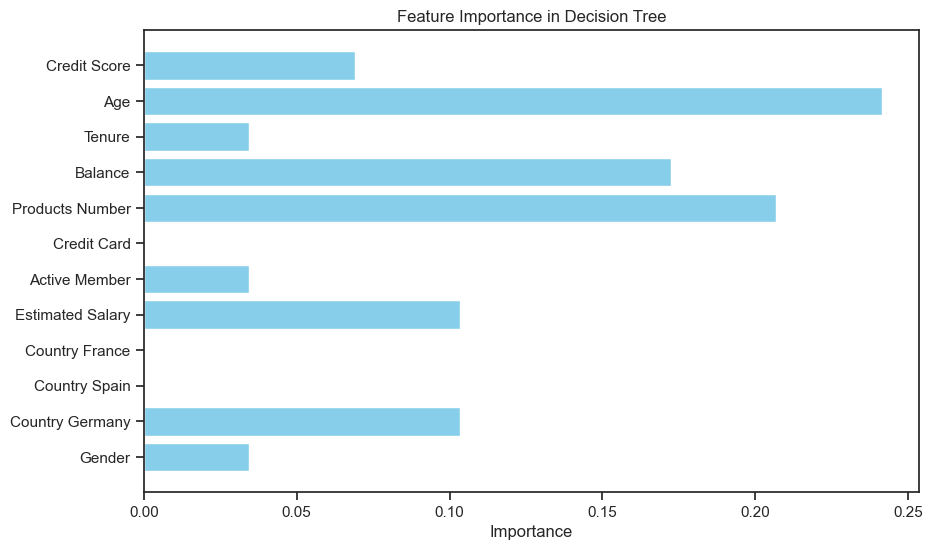

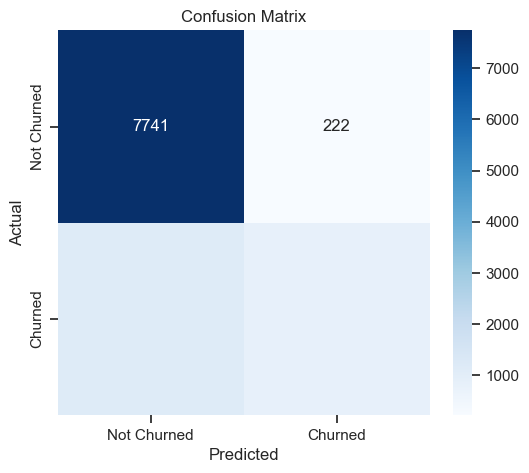

Accuracy: 85.89%
Precision: 79.25%
Recall: 41.63%
F1 Score: 54.59%


In [9]:
# A function to compute feature importance from the decision tree
def compute_feature_importance(tree, num_input_data, importance=None):
    if importance is None:
        importance = np.zeros(num_input_data)

    # If the tree is a leaf node return the current importance
    if not isinstance(tree, dict):
        return importance

    # Add importance for the current split
    input_data_index = tree['input_data_index']
    importance[input_data_index] += 1

    # Recursively calculate feature importance for left and right branches
    compute_feature_importance(tree['left'], num_input_data, importance)
    compute_feature_importance(tree['right'], num_input_data, importance)

    return importance / np.sum(importance)

# Compute feature importance using the trained decision tree
feature_importances = compute_feature_importance(final_tree, bank_input.shape[1])

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Decision Tree')
plt.gca().invert_yaxis() 
plt.show()

# Compute confusion matrix
conf_matrix = confusion_matrix(bank_labels, final_predictions_dt)

# Visualise the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate performance metrics
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1_score:.2%}")

Testing max_depth=3, Accuracy=77.69%
Testing max_depth=5, Accuracy=80.32%
Testing max_depth=7, Accuracy=81.71%
Testing max_depth=10, Accuracy=81.81%
Optimal max_depth from Grid Search: 10
Best Cross-Validation Accuracy after SMOTE: 81.81%


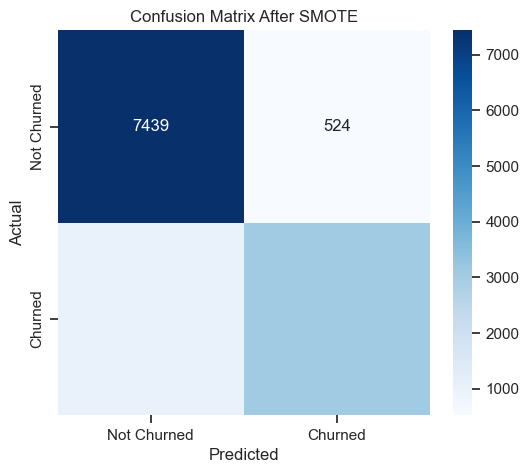

Accuracy: 87.16%
Precision: 85.35%
Recall: 74.94%
F1 Score: 79.81%


In [10]:
# A function to apply SMOTE
def synthetic_minority_oversampling(X, y, minority_class, k=5):
    # Select minority class samples
    minority_indices = np.where(y == minority_class)[0]
    X_minority = X[minority_indices]

    # Find k-nearest neighbours
    distances = compute_pairwise_distances(X_minority, X_minority)
    np.fill_diagonal(distances, np.inf)
    sorted_indices = np.argsort(distances, axis=1)[:, :k]

    # Generate new synthetic data
    synthetic_samples = []
    for i in range(len(X_minority)):
        neighbor_idx = np.random.choice(sorted_indices[i])
        diff = X_minority[neighbor_idx] - X_minority[i]
        gap = np.random.rand()
        synthetic_sample = X_minority[i] + gap * diff
        synthetic_samples.append(synthetic_sample)

    synthetic_samples = np.array(synthetic_samples)

    # Combine the original data with the generated synthetic data
    X_resampled = np.vstack((X, synthetic_samples))
    y_resampled = np.hstack((y, np.full(len(synthetic_samples), minority_class)))

    return X_resampled, y_resampled

# Apply oversampling
minority_class = 1
bank_input_resampled, bank_labels_resampled = synthetic_minority_oversampling(bank_input, bank_labels.ravel(), minority_class)

# Perform cross-validation and find the optimal parameters
num_folds = 5
max_depth_values = [3, 5, 7, 10]
optimal_max_depth, best_accuracy_dt = grid_search_dt(bank_input_resampled, bank_labels_resampled, num_folds, max_depth_values)

print(f"Optimal max_depth from Grid Search: {optimal_max_depth}")
print(f"Best Cross-Validation Accuracy after SMOTE: {best_accuracy_dt:.2%}")

#  Train decision tree with optimal parameters
final_tree = build_decision_tree(bank_input_resampled, bank_labels_resampled, max_depth=optimal_max_depth)

# Evalute performance on oversampled data
final_predictions_dt = predict_all(final_tree, bank_input_resampled)

# Compute confusion matrix
conf_matrix = confusion_matrix(bank_labels_resampled, final_predictions_dt)

# Visualise the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After SMOTE')
plt.show()

# Calculate performance metrics
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1_score:.2%}")